In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
room_type = "bathroom"
city_type = "large"

Load Latent Representations

In [7]:
#for using test data
savepath = f'/media/data_16T/nwl/processed_data/plots/20240116_{city_type}_cities'
#for using train data
#savepath = f'/media/data_16T/nwl/processed_data/plots/20240116_{city_type}_cities_train'

In [8]:
#for using test data
data = pd.read_csv(f'/home/klimenko/nwl/new_living_visual/Methodology/CLASSIFICATION/results/cities_{city_type}3_{room_type}/processed_model_v1_test.csv')
#for using train data
#data = pd.read_csv(f'/home/klimenko/nwl/new_living_visual/Methodology/CLASSIFICATION/results/cities_{city_type}3_{room_type}/processed_model_v1_train.csv').dropna(subset = ['latent'])

In [9]:
data.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,...,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,path,class,mode,id,latent,pred_city,pred_label,labels
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,/media/data_16T/nwl/datasets/airbnb/mexicoCity...,mexicoCity,test,642725.0,"0.37548536, 0.7217419, 0.15774225, 0.046593547...",mexicoCity,0.0,NaN
1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,/media/data_16T/nwl/datasets/airbnb/mexicoCity...,mexicoCity,test,12867139.0,"0.6849452, 0.26749507, 1.0259528, 0.20257765, ...",berlin,11.0,NaN
2,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,/media/data_16T/nwl/datasets/airbnb/mexicoCity...,mexicoCity,test,14550133.0,"0.9105103, 0.52251047, 0.6734984, 0.2296313, 0...",auckland,36.0,NaN
3,3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,/media/data_16T/nwl/datasets/airbnb/mexicoCity...,mexicoCity,test,12368205.0,"0.2318475, 0.20949174, 0.5343114, 0.19545612, ...",nairobi,18.0,NaN
4,4,4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,/media/data_16T/nwl/datasets/airbnb/mexicoCity...,mexicoCity,test,12368205.0,"0.06792202, 0.3533526, 0.6648483, 0.482887, 0....",nairobi,18.0,NaN


In [10]:
print(len(data))

14044


Prepare matrix of latent features

In [11]:
#parse comma seperated latent fetaures
def strToList(string):
    return [float(this_str.replace(' ','')) for this_str in string.split(',')]

In [12]:
n_features = len(strToList(data.iloc[0]['latent']))
n_samples = len(data)

In [13]:
latent_array = np.zeros((n_samples,n_features))
print(latent_array.shape)
for i in range(n_samples):
    latent_array[i] = strToList(data.iloc[i]['latent'])

(14044, 2048)


In [14]:
#compute global centroid in latent space
global_centroid = latent_array.mean(axis = 0).reshape(1,-1)
global_centroid.shape

(1, 2048)

In [15]:
#get list of cities in dataset
cities = list(data['pred_city'].unique())
cities

['mexicoCity',
 'berlin',
 'auckland',
 'nairobi',
 'cairo',
 'newYork',
 'lima',
 'chicago',
 'istanbul',
 'london',
 'paris',
 'rio',
 'dhaka',
 'toronto',
 'kinshasa',
 'buenosAires',
 'saoPaulo',
 'tokyo',
 'bogota',
 'madrid',
 'jakarta',
 'kolkata',
 'lahore',
 'milan',
 'dubai',
 'capeTown',
 'chennai',
 'seoul',
 'hongKong',
 'osaka',
 'losAngeles',
 'delhi',
 'bangkok',
 'adelaide',
 'melbourne',
 'sydney',
 'riyadh',
 'abidjan',
 'mumbai',
 'ankara']

Functions for computing latent representation metrics

In [16]:
def compute_dist(point1,point2):
    temp = point1 - point2
    sum_sq = np.dot(temp.T, temp)
    return np.sqrt(sum_sq)

In [17]:
def compute_dispersion(centroid, city_latent_arr):
    dist_sum = 0
    for i in range(len(city_latent_arr)):
        point = city_latent_arr[i]
        dist = compute_dist(point.reshape(-1), centroid.reshape(-1))
        dist_sum += dist
    return dist_sum/len(city_latent_arr)

In [18]:
city_data = {}
for index, city in enumerate(cities):
    print(index, city)
    city_df = data[data['pred_city']==city]
    city_latent_arr = np.zeros((len(city_df),n_features))
    print(city_latent_arr.shape)
    for i in range(len(city_df)):
        city_latent_arr[i] = strToList(city_df.iloc[i]['latent'])
    centroid = city_latent_arr.mean(axis = 0)
    print("Centroid", centroid)
    dispersion = compute_dispersion(centroid, city_latent_arr)
    print("Dispersion",dispersion)
    peripherality = compute_dist(centroid.reshape(-1), global_centroid.reshape(-1))
    print("Peripherality",peripherality)
    city_data[city] = {'centroid':centroid,'dispersion':dispersion, 'peripherality':peripherality}
    print("_______________")
city_df = pd.DataFrame(city_data).transpose().reset_index()
city_df.columns = ['city','centroid','dispersion','peripherality']

0 mexicoCity
(446, 2048)
Centroid [0.27984703 0.40824503 0.41565248 ... 0.32699488 0.28921985 0.23831813]
Dispersion 9.772002724645338
Peripherality 4.854857496711806
_______________
1 berlin
(501, 2048)
Centroid [0.2350408  0.32709654 0.46863292 ... 0.23422456 0.22579433 0.1571269 ]
Dispersion 11.549532996015897
Peripherality 9.626660378590023
_______________
2 auckland
(461, 2048)
Centroid [0.86396499 0.32302626 0.37635911 ... 0.22345653 0.1735335  0.13707717]
Dispersion 11.28918505969717
Peripherality 9.013186813373352
_______________
3 nairobi
(383, 2048)
Centroid [0.15043796 0.38092658 0.51078136 ... 0.32133264 0.28093212 0.52605018]
Dispersion 10.680263345265072
Peripherality 6.938198245378692
_______________
4 cairo
(397, 2048)
Centroid [0.21494645 0.28960391 0.6387064  ... 0.17203836 0.51825782 0.30597072]
Dispersion 11.717727677525408
Peripherality 8.9595009646252
_______________
5 newYork
(382, 2048)
Centroid [0.51792907 0.32856687 0.58223801 ... 0.15670381 0.16864054 0.19571

In [19]:
list(city_df['city'])

['mexicoCity',
 'berlin',
 'auckland',
 'nairobi',
 'cairo',
 'newYork',
 'lima',
 'chicago',
 'istanbul',
 'london',
 'paris',
 'rio',
 'dhaka',
 'toronto',
 'kinshasa',
 'buenosAires',
 'saoPaulo',
 'tokyo',
 'bogota',
 'madrid',
 'jakarta',
 'kolkata',
 'lahore',
 'milan',
 'dubai',
 'capeTown',
 'chennai',
 'seoul',
 'hongKong',
 'osaka',
 'losAngeles',
 'delhi',
 'bangkok',
 'adelaide',
 'melbourne',
 'sydney',
 'riyadh',
 'abidjan',
 'mumbai',
 'ankara']

In [20]:
city_df['dispersion'] = city_df['dispersion'].astype('float')
city_df['peripherality'] = city_df['peripherality'].astype('float')
city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city           40 non-null     object 
 1   centroid       40 non-null     object 
 2   dispersion     40 non-null     float64
 3   peripherality  40 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.4+ KB


Visualise dispersion and peripherality

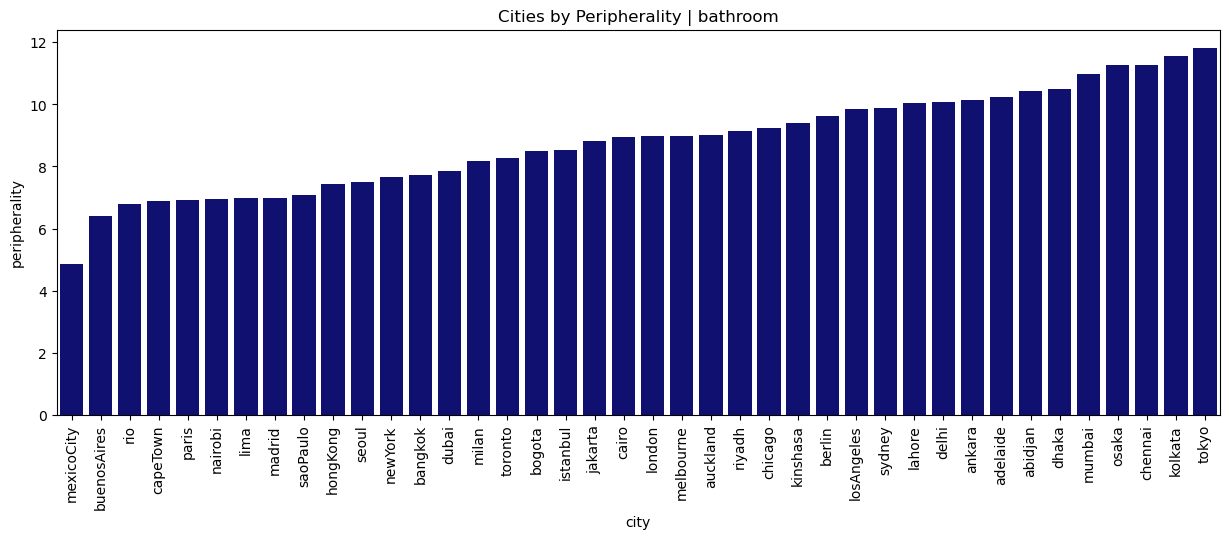

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'city', y = 'peripherality',data = city_df.sort_values('peripherality'), color = 'navy')
plt.xticks(rotation = '90')
plt.title(f'Cities by Peripherality | {room_type}')
plt.savefig(f'{savepath}/{room_type}_peripherality.png')

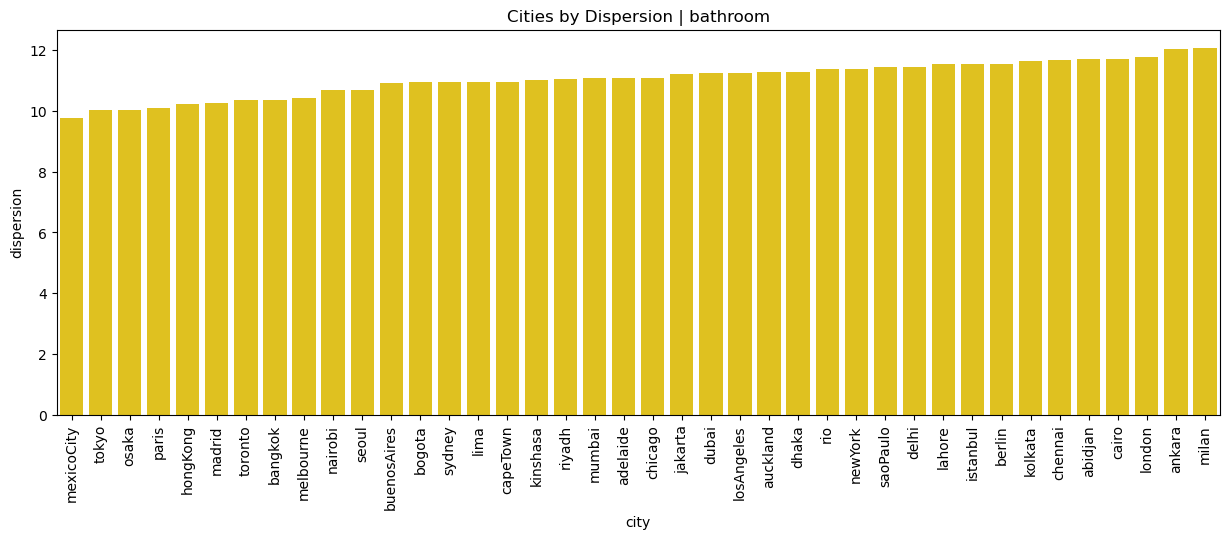

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'city', y = 'dispersion',data = city_df.sort_values('dispersion'), color = 'gold')
plt.xticks(rotation = '90')
plt.title(f'Cities by Dispersion | {room_type}')
plt.savefig(f'{savepath}/{room_type}_dispersion.png')

PearsonRResult(statistic=0.3232452468697441, pvalue=0.041897485619758916)


/home/sanatani/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


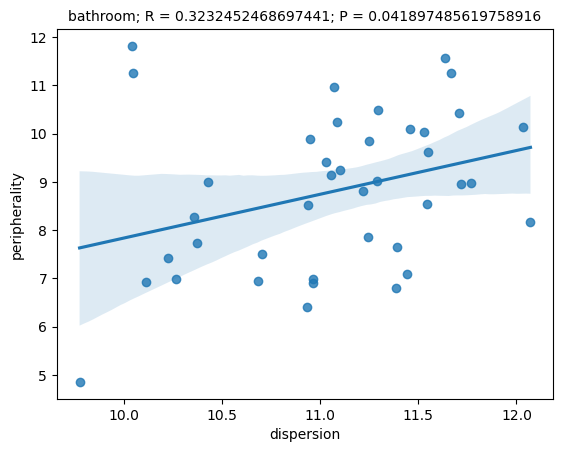

In [20]:
print(pearsonr(city_df['dispersion'],city_df['peripherality']))
plt.xlabel('Dispersion')
plt.ylabel('Peripherality')
plt.title(room_type+"; R = "+str(pearsonr(city_df['dispersion'],city_df['peripherality'])[0])+"; P = "+str(pearsonr(city_df['dispersion'],city_df['peripherality'])[1]),fontsize = 10)
sns.regplot(city_df['dispersion'],city_df['peripherality'])
plt.savefig(f'{savepath}/{room_type}_disp_per.png')

Define location attributes for each city

In [23]:
loc_dict = {
 'stockholm':[59.32323548870863, 18.070621563448984],
 'madrid':[40.40647320245658, -3.6967153812748963],
 'bangkok':[13.773233785050733, 100.5225445367279],
 'copenhagen':[55.679757829244295, 12.587985098181052],
 'newYork':[40.769862428030194, -73.97149117169842],
 'sydney':[-33.84438357119534, 151.22168379052175],
 'capeTown':[-33.94244608149376, 18.418424751950564],
 'lisbon':[38.744318301059685, -9.145662804793124],
 'london':[51.50954115152938, -0.09866048851878079],
 'boston':[42.36547679158646, -71.05780073657058],
 'vienna':[48.204418166827445, 16.370747428288592],
 'santiago':[-33.439716612646606, -70.64906957340331],
 'bordeaux':[44.84151437298221, -0.5734541965664937],
 'quebec':[46.81937417791963, -71.22256691741732],
 'rio':[-22.900310339570755, -43.2242999842336],
 'riga':[56.960794101138234, 24.10915192045564],
 'tokyo':[35.68082620402442, 139.7533801177331],
 'athens':[37.982211219955246, 23.727819611176923],
 'buenosAires':[-34.58668853627041, -58.42368883516564],
 'mexicoCity':[19.413974778271786, -99.13538873801195],
 'clarkCounty':[36.167725109357676, -115.14562360558303],
 'taipei':[25.049879939330847, 121.54062033811806],
 'paris':[48.858296827898656, 2.2946526641103335],
 'istanbul':[41.01389095627031, 28.980204382484093],
 'toronto':[43.651039688773814, -79.38025654717251],
 'berlin':[52.52098988976944, 13.411241721586277],
 'oslo':[59.908131118057184, 10.74650752002472],
 'brussels':[50.846190157113924, 4.352297406935314],
 'singapore':[1.2876318495900898, 103.8402633019032],
 'ghent':[51.05243109187996, 3.724741822417308],
 'zurich':[47.37258537013506, 8.5381863852651],
 'amsterdam':[52.37072792942398, 4.896748540063247],
 'pattaya':[12.93674282544811, 100.88643132991089],
 'johannesburg':[-26.206944569424465, 28.03822142914232],
 'adelaide':[-34.92753772612422, 138.59981285871837],
 'nairobi':[-1.291237284122005, 36.82769555457846],
 'dubai':[25.198156751989302, 55.27760120620652],
 'tangeri':[35.75460953796286, -5.825374430424291],
 'mumbai':[18.939841997602223, 72.83139203779065],
 'sharjah':[25.35979405840165, 55.43520929050558],    
 'margaretRiver':[-33.95345526658245, 115.07303956643081],
 'paarl':[-33.731061202192045, 18.96473498176573],
 'bakersfield':[35.37591986173433, -119.0533679000367],
 'islamabad':[33.69907657099544, 73.03657561953068],
 'siena':[43.318292233673944, 11.331796793697388],
 'nakuru':[-0.3030902418500127, 36.07994559836658],
 'toluca':[19.282584202399963, -99.6556261178933],
 'malaga':[36.71844586082829, -4.419792646034651],
 'lalitpur':[27.65865732811919, 85.32477869325484],
 'madison':[43.07323118635434, -89.40061127764758],
 'yerevan':[40.187174872187676, 44.51519062884697],
 'albany':[42.6518241951094, -73.75591200427526],
 'sunshineCoast':[-26.65074684625795, 153.08473258452773],
 'bath':[51.37778980199216, -2.359478803647732],
 'canberra':[-35.28189313796195, 149.12864828141159],
 'belize':[17.49606794063598, -88.18432261378896],
 'miyakami':[35.160573193740156, 139.062431335971],
 'wellington':[-41.29141748496088, 174.77958488496446],
 'heidelberg':[49.40795680056945, 8.676811398179565],
 'yamoussoukro':[6.818010936230788, -5.2797836523330846],
 'vitoria':[-20.318708816055373, -40.338094420857665],
 'trujillo':[-8.111109924566724, -79.02772561511844],
 'kandy':[7.296586694244546, 80.63608010734994],
 'gaborone':[-24.64225562324149, 25.911996367480583],
 'ibague':[4.432009859648496, -75.2105613681934],
 'denpasar':[-8.669793224567163, 115.22170702287978],
 'hualien':[23.981502574140453, 121.60924785312834],
 'varanasi':[25.321184665087216, 82.98969978735529],
 'eskisehir':[39.77081306164078, 30.519842192273853],
 'okayama':[34.661574671546155, 133.91442059321352],
 'amritsar':[31.634429949315727, 74.87158054014301],
 'manama':[26.230730983236022, 50.584597041075625],
 'luxor':[25.691058749440096, 32.6381893634443],
 'piracicaba':[-22.71823301111666, -47.65319785160872],
 'sylhet':[24.898821003553746, 91.86190847719371],
 'suncheon':[34.94539247284796, 127.50492653823571], 
 'milan' : [45.46423929419338, 9.190003682205964],
 'lima' : [-12.045225511943302, -77.04641375125273],
 'adelaide' : [-34.922639408195934, 138.601959583428],
 'abidjan' : [5.358272083569746, -4.015459564753941],
 'chicago' : [41.87619246634738, -87.61936400107136],
 'kinshasa' : [-4.308869731448921, 15.314845095533439],
 'seoul' : [37.54885755768013, 126.99224694706824],
 'losAngeles' : [34.07238229872347, -118.2442348477736],
 'cairo' : [30.04454922422871, 31.235718508468864],
 'bogota' : [4.657175406396891, -74.10507320317936],
 'melbourne' : [-37.82167721621972, 144.95636729599758],
 'hongKong' : [22.332438828732382, 114.19286525562055],
 'riyadh' : [24.72068842563838, 46.69520497979606],
 'auckland' : [-36.85434033765344, 174.76705142854027],
 'delhi' : [28.632797349561653, 77.21973414968087],
 'osaka' : [34.66571136790132, 135.47813821119863],
 'chennai' : [13.07924493550641, 80.28607509320933],
 'lahore' : [31.544884521504247, 74.34261780944885],
 'jakarta' : [-6.209928096127154, 106.8250335974979],
 'dhaka' : [23.793384947153225, 90.40251988360116],
 'cordoba' : [37.892070625001, -4.780879899106029],
 'saoPaulo' : [-23.532820750590954, -46.63172425949595],
 'kolkata' : [22.56264748804469, 88.36694594832053],
 'ankara' : [39.96144454449936, 32.86053243409409]
            }

name_dict = {
 'istanbul' : 'istanbul',
 'london' : 'london',
 'auckland' : 'auckland',
 'melbourne' : 'melbourne',
 'milan':'milan',
 'adelaide':'adelaide',
 'saoPaulo':'sao paulo',
 'buenosAires' : 'buenos aires',
 'abidjan':'abidjan' ,
 'lahore':'lahore',
 'newYork':'new york',
 'rio' : 'rio de janeiro',
 'cairo':'cairo',
 'toronto':'toronto',
 'sydney':'sydney',
 'bogota':'bogota',
 'mexicoCity':'mexico city',
 'lima':'lima',
 'kolkata':'kolkata',
 'capeTown':'cape town',
 'chennai':'chennai',
 'bangkok':'bangkok',
 'jakarta':'jakarta',
 'nairobi':'nairobi',
 'madrid':'madrid',
 'seoul':'seoul',
 'delhi':'delhi',
 'paris':'paris',
 'losAngeles':'los angeles',
 'berlin' : 'berlin',
 'chicago' : 'chicago',
 'hongKong':'hong kong',
 'osaka':'osaka',
 'tokyo':'tokyo',
 'dhaka':'dhaka',
 'riyadh':'riyadh',
 'ankara':'ankara',
 'dubai':'dubai',
 'kinshasa':'kinshasa',
 'mumbai':'mumbai'
}

def getName(city):
    return name_dict[city]

def getLat(city):
    return loc_dict[city][0]

def getLon(city):
    return loc_dict[city][1]

def getCountry(city):
    country_dict = {
 'stockholm': 'SE',
 'madrid': 'ES',
 'bangkok': 'TH',
 'copenhagen': 'DK',
 'newYork': 'US',
 'sydney': 'AU',
 'capeTown': 'ZA',
 'lisbon': 'PT',
 'london': 'UK', #not in list
 'boston':'US',
 'vienna':'AT',
 'santiago':'CL',
 'bordeaux':'FR',
 'quebec':'CA',
 'rio':'BR',
 'riga': 'LV',
 'tokyo': 'JP',
 'athens': 'GC', #not in list
 'buenosAires': 'AR',
 'mexicoCity': 'MX',
 'clarkCounty': 'US',
 'taipei': 'TW',
 'paris': 'FR',
 'istanbul': 'TR',
 'toronto': 'CA',
 'berlin': 'DE',
 'oslo': 'FL', #not in list
 'brussels': 'BE',
 'singapore': 'SG',
 'ghent': 'BE',
 'zurich': 'CH',
 'amsterdam':'NL',
 'pattaya':'TH',
 'johannesburg':'ZA',
 'adelaide':'AU',
 'nairobi':'KE',
 'dubai':'AE',
 'tangeri':'MA',
 'mumbai':'IN',
 'sharjah':'AE',
 'margaretRiver' : 'AU',
 'paarl' : 'ZA',
 'bakersfield' : 'US',
 'islamabad' : 'PK',
 'siena': 'IT', 
 'nakuru' : 'KE',
 'toluca' : 'MX',
 'malaga' : 'ES',
 'lalitpur' : 'NP',
 'madison' : 'US',
 'yerevan' : 'AM',
 'albany' : 'US',
 'sunshineCoast' : 'AU',
 'bath' : 'UK', #not in list
 'canberra' : 'AU',
 'belize' : 'BZ',
 'miyakami' : 'JP',
 'wellington' : 'NZ',
 'heidelberg' : 'DE',
 'yamoussoukro' : 'CI',
 'vitoria' : 'BR',
 'trujillo' : 'PE',
 'kandy' : 'LK',
 'gaborone' : 'BW',
 'ibague' : 'CO',
 'denpasar' : 'ID',
 'hualien' : 'TW',
 'varanasi' : 'IN',
 'eskisehir' : 'TR',
 'okayama' : 'JP',
 'amritsar' : 'IN',
 'manama' : 'BH',
 'luxor' : 'EG',
 'piracicaba':'BR',
 'sylhet':'BD',
 'suncheon':'KR',
 'milan' : 'IT',
 'lima' : 'PE',
 'adelaide' : 'AU',
 'abidjan' : 'CI',
 'chicago' : 'US',
 'kinshasa' : 'CD',
 'seoul' : 'KR',
 'losAngeles' : 'US',
 'cairo' : 'EG',
 'bogota' : "CO",
 'melbourne' : 'AU',
 'hongKong' : 'HK',
 'riyadh' : 'SA',
 'auckland' : 'NZ',
 'delhi' : 'IN',
 'osaka' : 'JP',
 'chennai' : 'IN',
 'lahore' : 'PK',
 'jakarta' : 'ID',
 'dhaka' : 'BD',
 'cordoba' : 'ES',
 'saoPaulo' : 'BR',
 'kolkata' : 'IN',
 'ankara' : 'TR'
    }
    return country_dict[city]

def getContinent(city):
    country_dict = {'stockholm': 'SE',
 'madrid': 'ES',
 'bangkok': 'TH',
 'copenhagen': 'DK',
 'newYork': 'US',
 'sydney': 'AU',
 'capeTown': 'ZA',
 'lisbon': 'PT',
 'london': 'UK', #not in list
 'boston':'US',
 'vienna':'AT',
 'santiago':'CL',
 'bordeaux':'FR',
 'quebec':'CA',
 'rio':'BR',
 'riga': 'LV',
 'tokyo': 'JP',
 'athens': 'GC', #not in list
 'buenosAires': 'AR',
 'mexicoCity': 'MX',
 'clarkCounty': 'US',
 'taipei': 'TW',
 'paris': 'FR',
 'istanbul': 'TR',
 'toronto': 'CA',
 'berlin': 'DE',
 'oslo': 'FL', #not in list
 'brussels': 'BE',
 'singapore': 'SG',
 'ghent': 'BE',
 'zurich': 'CH'}
    return country_dict[city]

def getName2(city):
    if ',' in city:
        return city.split(',')[0].lower()
    else:
        return city.split(' (')[0].lower()

In [24]:
#add lat lon information to dataframe
city_df['lat'] = city_df['city'].apply(getLat)
city_df['lon'] = city_df['city'].apply(getLon)
city_df['country'] = city_df['city'].apply(getCountry)
city_df['cityname'] = city_df['city'].apply(getName)
city_df

,city,centroid,dispersion,peripherality,lat,lon,country,cityname
0,mexicoCity,"[0.2798470301865472, 0.4082450305926006, 0.415...",9.772003,4.854857,19.413975,-99.135389,MX,mexico city
1,berlin,"[0.23504080051790416, 0.3270965355253492, 0.46...",11.549533,9.626660,52.520990,13.411242,DE,berlin
2,auckland,"[0.8639649936876358, 0.3230262626527116, 0.376...",11.289185,9.013187,-36.854340,174.767051,NZ,auckland
3,nairobi,"[0.1504379625917754, 0.3809265821671017, 0.510...",10.680263,6.938198,-1.291237,36.827696,KE,nairobi
4,cairo,"[0.2149464485538285, 0.2896039061909318, 0.638...",11.717728,8.959501,30.044549,31.235719,EG,cairo
5,newYork,"[0.5179290662905757, 0.32856687238743465, 0.58...",11.389782,7.647659,40.769862,-73.971491,US,new york
6,lima,"[0.2277205056761363, 0.8031271040909093, 0.282...",10.961285,6.995972,-12.045226,-77.046414,PE,lima
7,chicago,"[0.47398279641850183, 0.23787942639207016, 0.5...",11.098061,9.240982,41.876192,-87.619364,US,chicago
8,istanbul,"[0.3440390078743492, 0.21580325087267654, 0.67...",11.544638,8.545845,41.013891,28.980204,TR,istanbul
9,london,"[0.6837247340734267, 0.28393068107937064, 0.78...",11.767769,8.968511,51.509541,-0.098660,UK,london


In [26]:
print(len(city_df['country'].unique()))

30


In [32]:
#get flight operation data
fl_op_data_list = []
for i in range(1,6):
    fl_op_data = pd.read_excel(f'/media/data_16T/nwl/processed_data/flight_data/20240122_data_sample/Flights_operationaldata_2022_{i}.xlsx',sheet_name='Sheet0')
    fl_op_data_list.append(fl_op_data)
fl_op_data = pd.concat(fl_op_data_list)
fl_op_data['from_cityname'] = fl_op_data['From city'].apply(getName2)
fl_op_data['to_cityname'] = fl_op_data['To city'].apply(getName2)
fl_op_data.head()

/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles

,From city,To city,Year,Nb. of flights,Average seats available,Average payload capacity,from_cityname,to_cityname
0,BRNO (CZECHIA),OSTRAVA (CZECHIA),2022,5,189,16.80,brno,ostrava
1,BRNO (CZECHIA),PRAGUE (CZECHIA),2022,3,197,20.00,brno,prague
2,BRNO (CZECHIA),BOURGAS (BULGARIA),2022,56,189,16.80,brno,bourgas
3,BRNO (CZECHIA),VARNA (BULGARIA),2022,15,189,16.80,brno,varna
4,BRNO (CZECHIA),MARSA ALAM (EGYPT),2022,116,189,20.34,brno,marsa alam


In [33]:
#get flight passenger data
fl_pax_data_list = []
for i in range(1,6):
    fl_pax_data = pd.read_excel(f'/media/data_16T/nwl/processed_data/flight_data/20240122_data_sample/Flights_passengerdata_2022_{i}.xlsx',sheet_name='Sheet0')
    fl_pax_data_list.append(fl_pax_data)
fl_pax_data = pd.concat(fl_pax_data_list)
fl_pax_data['from_cityname'] = fl_pax_data['From city'].apply(getName2)
fl_pax_data['to_cityname'] = fl_pax_data['To city'].apply(getName2)
fl_pax_data.head()

/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/sanatani/anaconda3/lib/python3.9/site-packages/openpyxl/styles

,From city,To city,Year,Passengers revenue traffic,Seats available,Passenger occupancy factor,from_cityname,to_cityname
0,BRNO (CZECHIA),OSTRAVA (CZECHIA),2022,367,945,0.388,brno,ostrava
1,BRNO (CZECHIA),PRAGUE (CZECHIA),2022,555,590,0.941,brno,prague
2,BRNO (CZECHIA),BOURGAS (BULGARIA),2022,9213,10584,0.870,brno,bourgas
3,BRNO (CZECHIA),VARNA (BULGARIA),2022,2231,2835,0.787,brno,varna
4,BRNO (CZECHIA),MARSA ALAM (EGYPT),2022,19685,21924,0.898,brno,marsa alam


Compute correaltions of latent space distance with geographic distance and flight traffic

In [34]:
from math import radians, cos, sin, asin, sqrt
def compute_geoDistance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

def compute_distance(point1,point2):
    temp = point1-point2
    sum_sq = np.dot(temp.T, temp)
    return np.sqrt(sum_sq)

def compute_n_flights(city1, city2):
    flights1 = fl_op_data[(fl_op_data['from_cityname'] == city1) & (fl_op_data['to_cityname'] == city2)]
    flights2 = fl_op_data[(fl_op_data['from_cityname'] == city2) & (fl_op_data['to_cityname'] == city1)]
    if len(flights1) == 0:
        n_flights1 = 0
    else:
        n_flights1 = list(flights1['Nb. of flights'])[0]
    if  len(flights2) == 0:
        n_flights2 = 0
    else:
        n_flights2 = list(flights2['Nb. of flights'])[0]
    return n_flights1+n_flights2

def compute_pax_traffic(city1, city2):
    flights1 = fl_pax_data[(fl_pax_data['from_cityname'] == city1) & (fl_pax_data['to_cityname'] == city2)]
    flights2 = fl_pax_data[(fl_pax_data['from_cityname'] == city2) & (fl_pax_data['to_cityname'] == city1)]
    if len(flights1) == 0:
        pax_flights1 = 0
    else:
        pax_flights1 = list(flights1['Passengers revenue traffic'])[0]
    if  len(flights2) == 0:
        pax_flights2 = 0
    else:
        pax_flights2 = list(flights2['Passengers revenue traffic'])[0]
    return pax_flights1+pax_flights2

def find_pairs(city1, city2):
    flights1 = fl_op_data[(fl_op_data['from_cityname'] == city1) & (fl_op_data['to_cityname'] == city2)]
    flights2 = fl_op_data[(fl_op_data['from_cityname'] == city2) & (fl_op_data['to_cityname'] == city1)]
    
    return pd.concat([flights1,flights2])

In [35]:
locations = city_df[['lat','lon']].to_numpy()
locations.shape

(40, 2)

In [36]:
citynames = list(city_df['cityname'])
citynames

['mexico city',
 'berlin',
 'auckland',
 'nairobi',
 'cairo',
 'new york',
 'lima',
 'chicago',
 'istanbul',
 'london',
 'paris',
 'rio de janeiro',
 'dhaka',
 'toronto',
 'kinshasa',
 'buenos aires',
 'sao paulo',
 'tokyo',
 'bogota',
 'madrid',
 'jakarta',
 'kolkata',
 'lahore',
 'milan',
 'dubai',
 'cape town',
 'chennai',
 'seoul',
 'hong kong',
 'osaka',
 'los angeles',
 'delhi',
 'bangkok',
 'adelaide',
 'melbourne',
 'sydney',
 'riyadh',
 'abidjan',
 'mumbai',
 'ankara']

In [37]:
points = np.zeros((len(city_df),n_features))
countries = []
for i in range(len(city_df)):
    points[i] = city_df.iloc[i]['centroid']
    countries.append(city_df.iloc[i]['country'])
print(points.shape)
print(len(countries))

(40, 2048)
40


In [38]:
# for all possible pairs in dataframe, compute geodist and latent_dist
result = {"distance":[],
          "geoDist":[],
          "n_flights":[],
          "n_pax":[],
          "locations":[], 
          "country_pairs": [],
          "city_pairs":[]}
n = len(points)
for i in range(n):
    for j in range(i+1, n):     
        result['distance'].append(compute_distance(points[i],points[j]))
        result["geoDist"].append(compute_geoDistance(locations[i][0], locations[j][0], locations[i][1], locations[j][1]))
        result["n_flights"].append(compute_n_flights(citynames[i],citynames[j]))
        result["n_pax"].append(compute_pax_traffic(citynames[i],citynames[j]))
        result["locations"].append([list(locations[i]),list(locations[j])])
        result["country_pairs"].append([countries[i],countries[j]])
        result["city_pairs"].append([citynames[i],citynames[j]])

In [41]:
print("Total city pairs:",len(result['geoDist']))

Total city pairs: 780


In [42]:
pair_data_all = pd.DataFrame(result)
pair_data_all.head()

,distance,geoDist,n_flights,n_pax,locations,country_pairs,city_pairs
0,11.946798,9728.823698,0,0,"[[19.413974778271786, -99.13538873801195], [52...","[MX, DE]","[mexico city, berlin]"
1,11.270789,10953.937956,0,0,"[[19.413974778271786, -99.13538873801195], [-3...","[MX, NZ]","[mexico city, auckland]"
2,7.831432,14818.054730,0,0,"[[19.413974778271786, -99.13538873801195], [-1...","[MX, KE]","[mexico city, nairobi]"
3,11.646521,12370.200193,0,0,"[[19.413974778271786, -99.13538873801195], [30...","[MX, EG]","[mexico city, cairo]"
4,9.927799,3367.279957,5496,787844,"[[19.413974778271786, -99.13538873801195], [40...","[MX, US]","[mexico city, new york]"


In [43]:
pair_data_filt = pair_data_all[pair_data_all['n_flights'] != 0]
pair_data_filt_pax = pair_data_all[pair_data_all['n_pax'] != 0]
print(len(pair_data_filt))
print(len(pair_data_filt_pax))

238
217


Plot correlations between geographic distance and latent space distance

/home/sanatani/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


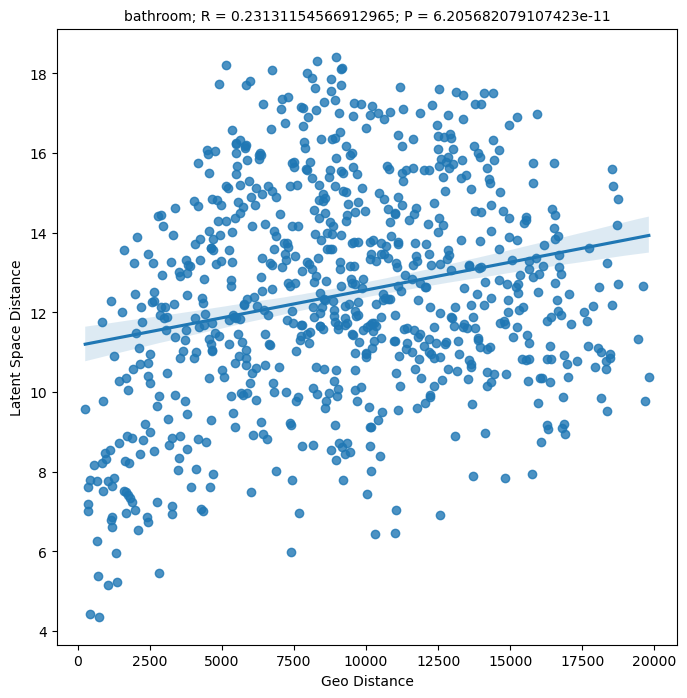

In [44]:
plt.figure(figsize=(8,8))
sns.regplot(result['geoDist'],result['distance'])
plt.xlabel('Geo Distance')
plt.ylabel('Latent Space Distance')
plt.title(room_type+"; R = "+str(pearsonr(result['geoDist'],result['distance'])[0])+"; P = "+str(pearsonr(result['geoDist'],result['distance'])[1]),fontsize = 10)
plt.savefig(f'{savepath}/{room_type}_geo_dist.png')

Plot correlations between flight traffic and latent space distance

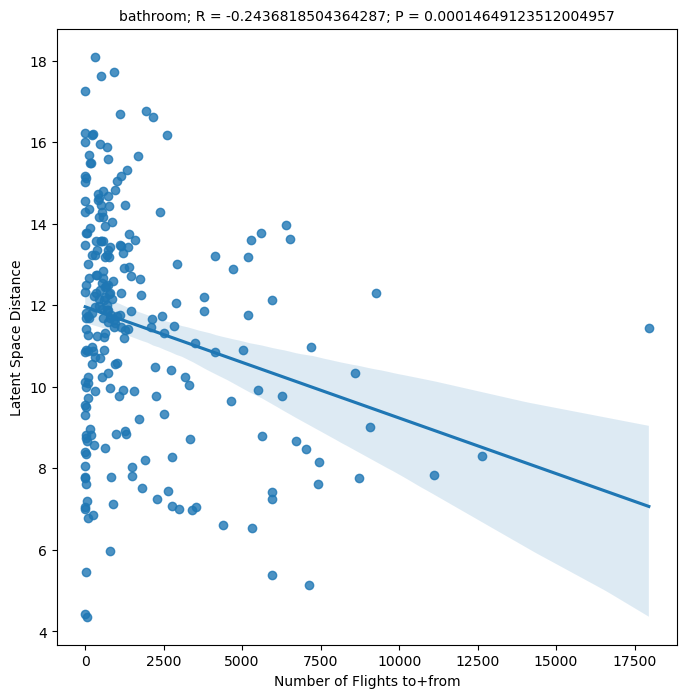

In [45]:
plt.figure(figsize=(8,8))
sns.regplot(pair_data_filt['n_flights'],pair_data_filt['distance'])
plt.xlabel('Number of Flights to+from')
plt.ylabel('Latent Space Distance')
plt.title(room_type+"; R = "+str(pearsonr(pair_data_filt['n_flights'],pair_data_filt['distance'])[0])+"; P = "+str(pearsonr(pair_data_filt['n_flights'],pair_data_filt['distance'])[1]),fontsize = 10)
plt.savefig(f'{savepath}/{room_type}_flights_dist_filtered.png')

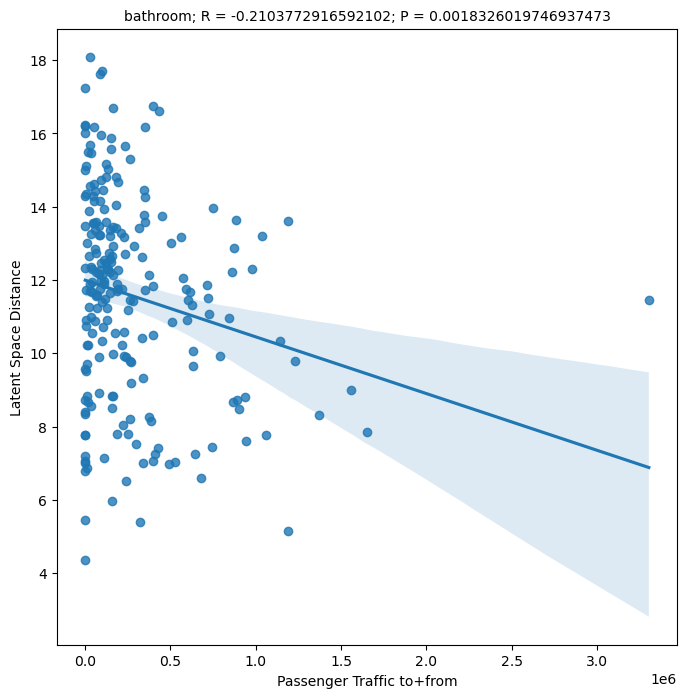

In [46]:
plt.figure(figsize=(8,8))
sns.regplot(pair_data_filt_pax['n_pax'],pair_data_filt_pax['distance'])
plt.xlabel('Passenger Traffic to+from')
plt.ylabel('Latent Space Distance')
plt.title(room_type+"; R = "+str(pearsonr(pair_data_filt_pax['n_pax'],pair_data_filt_pax['distance'])[0])+"; P = "+str(pearsonr(pair_data_filt_pax['n_pax'],pair_data_filt_pax['distance'])[1]),fontsize = 10)
plt.savefig(f'{savepath}/{room_type}_flights_traffic_dist_filtered.png')